Google Colab is cool

In [ ]:
!nvidia-smi

Thu Apr 17 20:03:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check current versions
!python -c "import numpy; print('Current numpy version:', numpy.__version__)"
!python -c "import torch; print('Current torch version:', torch.__version__)"

# Install desired versions with CUDA 12.4
!pip install numpy==1.26.4
!pip install torch==2.3.0+cu124 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu124.html
!pip install torcheeg
!pip install pytorch-lightning

# This will show the versions in new Python processes
!python -c "import numpy; print('Installed numpy version:', numpy.__version__)"
!python -c "import torch; print('Installed torch version:', torch.__version__)"

print("\n*** IMPORTANT: Please restart the runtime now for changes to take effect in this notebook  (search for 'restart session' in top left 'commands' ***")

Current numpy version: 2.0.2
Current torch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.3.0+cu124 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2

In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    accelerator = "gpu"
    pin_memory = True
    print("GPU is available. Training will use GPU acceleration.")
else:
    accelerator = "cpu"
    pin_memory = False
    print("WARNING: GPU not available, using CPU instead")

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
GPU is available. Training will use GPU acceleration.


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
experiment_name = input("name your experiment (or use old one) > ")  # like sst_01

name your experiment (or use old one) > sst_02


In [5]:
import os

IO_PATH = f'/content/drive/MyDrive/datasets/STEW/io/{experiment_name}/' # not-existant or populated - ! NOT EMPTY !
MODEL_SAVE_PATH = f'/content/drive/MyDrive/datasets/STEW/model/{experiment_name}/' # is going to be created if it doesn't exist yet
DATA_FOLDER_PATH = '/content/drive/MyDrive/datasets/STEW/dataset' # has to exist

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"model folder not existing, creating at {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"ATTENTION: model folder already exists, only proceed if you are ready to overwrite")

if not os.path.exists(DATA_FOLDER_PATH):
    raise Exception("make sure dataset exists")


SEED:int = 42
BATCH_SIZE:int = 64
N_WORKERS:int = 2

model folder not existing, creating at /content/drive/MyDrive/datasets/STEW/model/sst_02/


# loading data

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.8 MB/s eta 0:00:00


In [6]:
import os
import numpy as np
import mne
from typing import List, Dict
from tqdm import tqdm


def load_stew_dataset(stew_path: str, subjects: List[int] = None) -> tuple:
    """
    Load the STEW (Sustained-Task EEG Workload) dataset from TXT files.

    Parameters:
        stew_path (str): Path to the STEW dataset directory
        subjects (List[int], optional): List of subject IDs to load. If None, loads all available subjects.

    Returns:
        tuple: (raw_list, info_list) for use with MNERawDataset
    """
    # EEG channel names in the correct order
    channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

    # If no subjects specified, find all available subjects
    # if subjects is None:
    #     subjects = set()
    #     for filename in os.listdir(stew_path):
    #         if filename.startswith('sub') and filename.endswith('.txt'):
    #             try:
    #                 subject_id = int(filename[3:5])
    #                 subjects.add(subject_id)
    #             except ValueError:
    #                 continue
    #     subjects = sorted(list(subjects))

    raw_list = []
    info_list = []

    # Task mapping
    task_mapping = {
        'lo': 'low',
        'hi': 'high'
    }

    for subject in tqdm(subjects):
        # Format subject ID with leading zero if needed
        subject_str = f"{subject:02d}"

        # Check for both task conditions
        for task_code in ['lo', 'hi']:
            filename = f"sub{subject_str}_{task_code}.txt"
            file_path = os.path.join(stew_path, filename)

            if os.path.exists(file_path):
                try:
                    # Load EEG data from txt file
                    eeg_data = np.loadtxt(file_path)

                    # Assume sampling rate of 128 Hz (adjust if different)
                    sfreq = 128

                    # Create MNE info structure
                    info = mne.create_info(
                        ch_names=channel_names,
                        sfreq=sfreq,
                        ch_types=['eeg'] * len(channel_names)
                    )

                    # Create Raw object
                    raw = mne.io.RawArray(eeg_data.T, info)

                    # Create metadata dictionary
                    metadata = {
                        'subject_id': subject,
                        'task': task_mapping[task_code],
                        'trial_id': task_code,
                        'workload_level': 0 if task_code == 'lo' else 1
                    }

                    raw_list.append(raw)
                    info_list.append(metadata)

                    # print(f"Loaded {filename}: {eeg_data.shape} samples")

                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    return raw_list, info_list


raw_list, info_list = load_stew_dataset(DATA_FOLDER_PATH)
print(f"\n\nLoaded {len(raw_list)} recordings from {len(set([info['subject_id'] for info in info_list]))} subjects")

  0%|          | 0/48 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  2%|▏         | 1/48 [00:01<01:27,  1.87s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  4%|▍         | 2/48 [00:02<00:58,  1.27s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  6%|▋         | 3/48 [00:03<00:48,  1.08s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  8%|▊         | 4/48 [00:04<00:42,  1.03it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 10%|█         | 5/48 [00:05<00:38,  1.12it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 12%|█▎        | 6/48 [00:06<00:37,  1.11it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 15%|█▍        | 7/48 [00:06<00:36,  1.14it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 17%|█▋        | 8/48 [00:07<00:32,  1.22it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 19%|█▉        | 9/48 [00:08<00:30,  1.26it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 21%|██        | 10/48 [00:09<00:29,  1.27it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 23%|██▎       | 11/48 [00:09<00:28,  1.32it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 25%|██▌       | 12/48 [00:10<00:26,  1.34it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 27%|██▋       | 13/48 [00:11<00:26,  1.31it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 29%|██▉       | 14/48 [00:12<00:27,  1.23it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 31%|███▏      | 15/48 [00:13<00:26,  1.25it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 33%|███▎      | 16/48 [00:13<00:25,  1.27it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 35%|███▌      | 17/48 [00:14<00:24,  1.26it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 38%|███▊      | 18/48 [00:15<00:23,  1.26it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 40%|███▉      | 19/48 [00:16<00:23,  1.24it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 42%|████▏     | 20/48 [00:17<00:23,  1.20it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 44%|████▍     | 21/48 [00:17<00:22,  1.22it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 46%|████▌     | 22/48 [00:18<00:20,  1.26it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 48%|████▊     | 23/48 [00:19<00:19,  1.31it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 50%|█████     | 24/48 [00:19<00:17,  1.35it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 52%|█████▏    | 25/48 [00:20<00:17,  1.33it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 54%|█████▍    | 26/48 [00:21<00:16,  1.35it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 56%|█████▋    | 27/48 [00:22<00:15,  1.35it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 58%|█████▊    | 28/48 [00:23<00:15,  1.32it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 60%|██████    | 29/48 [00:23<00:13,  1.38it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 62%|██████▎   | 30/48 [00:24<00:13,  1.37it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 65%|██████▍   | 31/48 [00:25<00:12,  1.33it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 67%|██████▋   | 32/48 [00:25<00:11,  1.34it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 69%|██████▉   | 33/48 [00:26<00:11,  1.35it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 71%|███████   | 34/48 [00:27<00:10,  1.37it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 73%|███████▎  | 35/48 [00:28<00:09,  1.31it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 75%|███████▌  | 36/48 [00:29<00:11,  1.07it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 77%|███████▋  | 37/48 [00:30<00:11,  1.07s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 79%|███████▉  | 38/48 [00:31<00:10,  1.02s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 81%|████████▏ | 39/48 [00:32<00:08,  1.01it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 83%|████████▎ | 40/48 [00:33<00:07,  1.08it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 85%|████████▌ | 41/48 [00:34<00:06,  1.16it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 88%|████████▊ | 42/48 [00:35<00:04,  1.21it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 90%|████████▉ | 43/48 [00:35<00:04,  1.23it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 92%|█████████▏| 44/48 [00:36<00:03,  1.20it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 94%|█████████▍| 45/48 [00:37<00:02,  1.28it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 96%|█████████▌| 46/48 [00:38<00:01,  1.27it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 98%|█████████▊| 47/48 [00:39<00:00,  1.12it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


100%|██████████| 48/48 [00:40<00:00,  1.19it/s]



Loaded 96 recordings from 48 subjects


<RawArray | 14 x 19200 (150.0 s), ~2.1 MiB, data loaded>
['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] None
Using matplotlib as 2D backend.


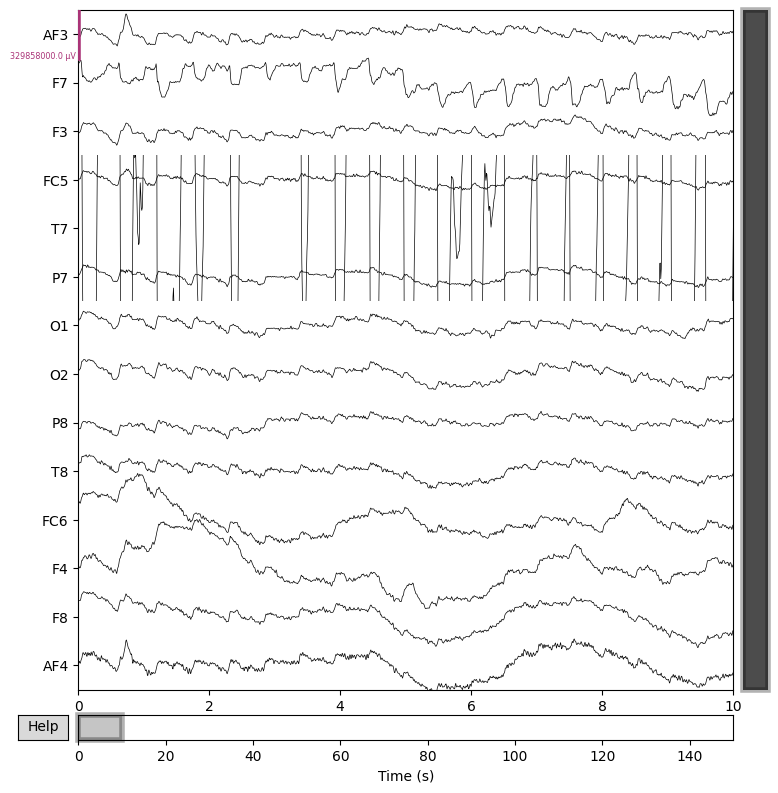

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


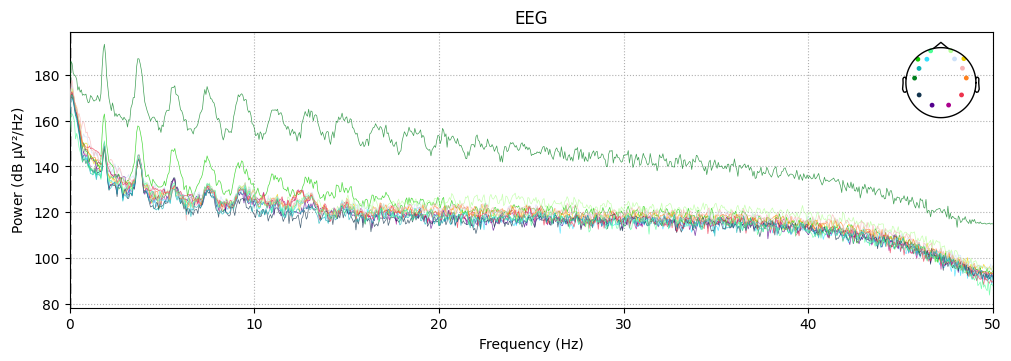

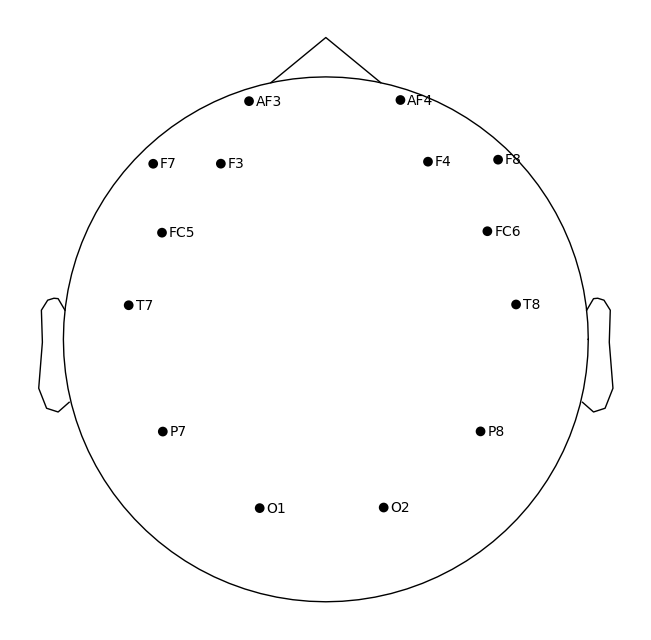

NOTE: plot_psd_topo() is a legacy function. New code should use .compute_psd().plot_topo().
Effective window size : 16.000 (s)


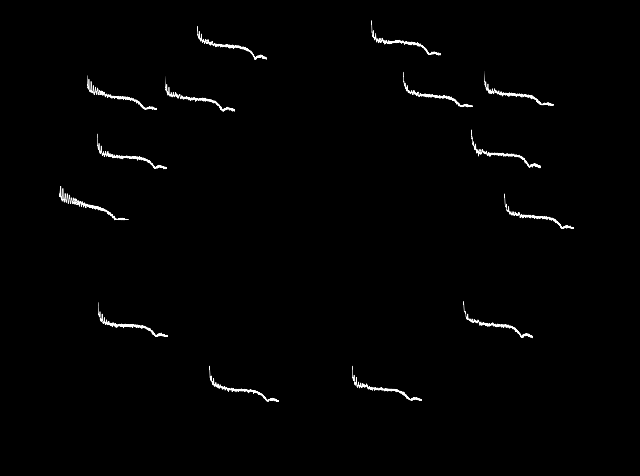

In [7]:
import random
import matplotlib.pyplot as plt

raw = random.choice(raw_list)

print(raw)
print(raw.info["ch_names"], raw.get_montage())

montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

# raw.filter(1, 40)  # Bandpass filter from 1-40 Hz

# plot raw graph
fig = raw.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')

# Plot power spectral density
fig_psd = raw.plot_psd(fmax=50)

# Plot topographic map of channel positions
fig_topo = raw.plot_sensors(show_names=True)

# plot the Power-Spectral-Density for each frequency - has a safety mechanism to not display frequencies you couldn't have captured (Nyquist-Shannon sampling theory)
fig_psd_bands = raw.plot_psd_topo(fmax=60)

plt.show()

In [ ]:
from torcheeg.datasets import MNERawDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from typing import Tuple

# https://ieee-dataport.org/open-access/stew-simultaneous-task-eeg-workload-dataset
# Wei Lun Lim, Olga Sourina, Lipo Wang, July 10, 2018, "STEW: Simultaneous Task EEG Workload Dataset", IEEE Dataport, doi: https://dx.doi.org/10.21227/44r8-ya50.
# we predict the cognitive load based on EEG data (by mapping hard tasks to "high" label and easy ones to "low" label)

# if this is throwing an error about corrupted, make sure the folder is
# populated by the right stuff (from running this thing the last time)
# or does NOT exist - will only run once and populate io path

# !! has to match the channel names in the info of the MNE raw objects
STEW_CHANNEL_LOCATION_DICT = {
    'AF3': (-0.3, 0.8),
    'F7': (-0.8, 0.4),
    'F3': (-0.4, 0.7),
    'FC5': (-0.8, 0.0),
    'T7': (-1.0, -0.2),
    'P7': (-0.8, -0.6),
    'O1': (-0.4, -1.0),
    'O2': (0.4, -1.0),
    'P8': (0.8, -0.6),
    'T8': (1.0, -0.2),
    'FC6': (0.8, 0.0),
    'F4': (0.4, 0.7),
    'F8': (0.8, 0.4),
    'AF4': (0.3, 0.8)
}

offline_transform = transforms.Compose([
    transforms.Concatenate([

        transforms.Compose([
            transforms.BandDifferentialEntropy(
                band_dict={
                    'theta': [4, 8],
                    'alpha': [8, 13],
                    'beta': [13, 30],
                    'gamma': [30, 45]
                },
                sampling_rate=128
            ),
            transforms.MeanStdNormalize()
        ]),
        transforms.Compose([
            transforms.Downsample(num_points=32),
            transforms.MinMaxNormalize()
        ])
    ]),

    transforms.ToInterpolatedGrid(STEW_CHANNEL_LOCATION_DICT)
])

online_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16, 16))
])

label_transform = transforms.Compose([
    transforms.Select('workload_level')
])


# --- A. keep class and don't multiprocessing to avoid serialization problem
dataset = MNERawDataset(
    io_path=IO_PATH,

    raw_list=raw_list,
    info_list=info_list,
    chunk_size=640,  # 5 seconds at 128 Hz (better for cognitive load)
    overlap=320,     # 50% overlap

    offline_transform=offline_transform,
    online_transform=online_transform,
    label_transform=label_transform,

    num_worker=0,
    verbose=False
)

# --- B. fix it
# class SerializableMNERawDataset(MNERawDataset):
#     """

#     we override the behavior, so that we turn the objects into numpy first and
#     then back again into raw objects, so that the serialization works when passing
#     it to the workers
#     """
#     def __init__(self, *args, **kwargs):
#         # Store raw data separately
#         self._raw_data_list = []
#         self._raw_params_list = []

#         # Extract data from raw objects
#         raw_list = kwargs.pop('raw_list')
#         for raw in raw_list:
#             data, times = raw[:, :]
#             ch_names = raw.ch_names
#             sfreq = raw.info['sfreq']

#             self._raw_data_list.append(data)
#             self._raw_params_list.append({
#                 'ch_names': ch_names,
#                 'sfreq': sfreq,
#                 'times': times
#             })

#         # Create dummy raw_list for parent class
#         kwargs['raw_list'] = [None] * len(raw_list)
#         super().__init__(*args, **kwargs)

#     @staticmethod
#     def process_record(record: Tuple, **kwargs):
#         raw, info, raw_data, raw_params = record

#         # Recreate raw object from data
#         info_obj = mne.create_info(
#             ch_names=raw_params['ch_names'],
#             sfreq=raw_params['sfreq'],
#             ch_types=['eeg'] * len(raw_params['ch_names'])
#         )
#         raw = mne.io.RawArray(raw_data, info_obj)

#         # Call original process_record with recreated raw
#         return MNERawDataset.process_record((raw, info), **kwargs)

#     def set_records(self, raw_list, info_list, **kwargs):
#         # Combine raw placeholders, info, and the actual data
#         return list(zip(raw_list, info_list, self._raw_data_list, self._raw_params_list))


# dataset = SerializableMNERawDataset(
#     io_path=IO_PATH,

#     raw_list=raw_list,
#     info_list=info_list,
#     chunk_size=640,  # 5 seconds at 128 Hz (better for cognitive load)
#     overlap=320,     # 50% overlap

#     offline_transform=offline_transform,
#     online_transform=online_transform,
#     label_transform=label_transform,

#     num_worker=N_WORKERS,
#     verbose=True
# )


# ---

print(f"Dataset size: {len(dataset)}")
sample = dataset[0]
eeg_data, label = sample

print(f"EEG data shape: {eeg_data.shape}")
print(f"Label: {label}")

[2025-04-17 20:27:52] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_01/.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_01/.
[2025-04-17 20:27:52] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:   0%|          | 0/96 [00:00<?, ?it/s]
[RECORD (<RawArray | 14 x 19200 (150.0 s), ~2.1 MiB, data loaded>, {'subject_id': 1, 'task': 'low', 'trial_id': 'lo', 'workload_level': 0})]: 0it [00:00, ?it/s]
[RECORD (<RawArray | 14 x 19200 (150.0 s), ~2.1 MiB, data loaded>, {'subject_id': 1, 'task': 'low', 'trial_id': 'lo', 'workload_level':

Dataset size: 5664
EEG data shape: torch.Size([36, 16, 16])
Label: 0


In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader


# validation is used during training for evaluating each batch
# test is saved to after (even if we don't train on val anyway, mechanisms like picking the best may still have 'val bias')
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")



# when training a GPU, we put the memory on a special 'pinned' region for faster transfer between CPU and GPU
# we shuffle the data in training to avoid it learning some patterns there (across batches) - no need on eval, since metrics will be the same
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

# the grid:
# - channels mapped to a grid (not every one has an electrode)
# - each frequency band has its own grid, similar to how we have multiple values for RGB
# - determined by the DICT we enter into transform (though we might resize it)

for batch in train_loader:
    print(f"Input shape: {batch[0].shape}")
    break

# SST:([64, 36, 16, 16]) - ([batch_size, n_bands, grid_dim, grid_dim])

Dataset split: 3964 training, 849 validation, 851 test samples
Input shape: torch.Size([64, 36, 16, 16])


# initializing model

In [ ]:
# depends on your dataset, duh?
N_CLASSES:int = 2

In [ ]:
# --- SST (47min, stopped on epoch 35)
from torcheeg.models import SSTEmotionNet
model = SSTEmotionNet(
    temporal_in_channels=32, # 32 "frames" stacked
    spectral_in_channels=4, # 4 bands
    grid_size=(16, 16), # min size for some reason
    num_classes=N_CLASSES
)

#actual training (don't run for inference only)

In [ ]:
from torcheeg.trainers import ClassifierTrainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = ClassifierTrainer(
    model=model,
    num_classes=N_CLASSES,
    lr=5e-5,
    weight_decay=1e-4,
    accelerator=accelerator,
    metrics=["accuracy", "precision", "recall", "f1score"]
)

callbacks = [
    # saves the best model (for recalling after plateu)
    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='best-model-{epoch:02d}-{val_accuracy:.4f}',
        monitor='val_accuracy',
        mode='max',
        save_top_k=1
    ),

    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='last-model',
        save_last=True
    ),

    # detect overfitting and end if val_accuracy stops improving for 10 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        verbose=True
    )
]

In [ ]:
print("\nStarting model training...")
trainer.fit(
    train_loader,
    val_loader,
    max_epochs=100,
    default_root_dir=MODEL_SAVE_PATH,
    callbacks=callbacks,
    enable_progress_bar=True,
    enable_model_summary=True
)

# ends once the trainer is done (so most likely through EarlyStop, otherwise max_epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/datasets/STEW/model/sst_01 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Starting model training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:01] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.703 val_accuracy: 0.445 val_precision: 0.223 val_recall: 0.500 val_f1score: 0.308 
INFO:torcheeg:
[Val] val_loss: 0.703 val_accuracy: 0.445 val_precision: 0.223 val_recall: 0.500 val_f1score: 0.308 


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:07] INFO (torcheeg/MainThread) 
[Val] val_loss: 1050.317 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
INFO:torcheeg:
[Val] val_loss: 1050.317 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
[2025-04-17 20:37:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.695 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.695 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_accuracy improved. New best score: 0.508


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:13] INFO (torcheeg/MainThread) 
[Val] val_loss: 9.291 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
INFO:torcheeg:
[Val] val_loss: 9.291 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
[2025-04-17 20:37:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:18] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-17 20:37:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:24] INFO (torcheeg/MainThread) 
[Val] val_loss: 121545376661504.000 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
INFO:torcheeg:
[Val] val_loss: 121545376661504.000 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
[2025-04-17 20:37:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:29] INFO (torcheeg/MainThread) 
[Val] val_loss: 11858118656.000 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
INFO:torcheeg:
[Val] val_loss: 11858118656.000 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
[2025-04-17 20:37:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:34] INFO (torcheeg/MainThread) 
[Val] val_loss: 3263602.000 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
INFO:torcheeg:
[Val] val_loss: 3263602.000 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
[2025-04-17 20:37:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.694 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:40] INFO (torcheeg/MainThread) 
[Val] val_loss: 283.104 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
INFO:torcheeg:
[Val] val_loss: 283.104 val_accuracy: 0.508 val_precision: 0.254 val_recall: 0.500 val_f1score: 0.337 
[2025-04-17 20:37:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:45] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.693 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 0.693 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-17 20:37:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-17 20:37:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:37:58] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-17 20:37:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:38:04] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 0.694 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-17 20:38:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.504 train_precision: 0.252 train_recall: 0.500 train_f1score: 0.335 
INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_accuracy did not improve in the last 10 records. Best score: 0.508. Signaling Trainer to stop.


In [ ]:
print("\nEvaluating model on test set...")
test_results = trainer.test(test_loader)[0]
print(test_results)
print(f"Test accuracy: {test_results['test_accuracy']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating model on test set...


Testing: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:39:15] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 
INFO:torcheeg:
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4888366758823395     │
│       test_f1score        │    0.32833465933799744    │
│         test_loss         │    0.6938510537147522     │
│      test_precision       │    0.24441833794116974    │
│        test_recall        │            0.5            │
└───────────────────────────┴───────────────────────────┘

{'test_loss': 0.6938510537147522, 'test_accuracy': 0.4888366758823395, 'test_precision': 0.24441833794116974, 'test_recall': 0.5, 'test_f1score': 0.32833465933799744}
Test accuracy: 0.4888


# loading model and doing inference

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import os

for fname in os.listdir(MODEL_SAVE_PATH):
    if fname.startswith("best-model") and fname.endswith(".ckpt"):
        break


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# continuing code will fail if for some reason there is no file called best-model-...ckpt
# (is automatically created due to our callbacks in training)
ckpt_path = MODEL_SAVE_PATH + fname

print(f"Loading {ckpt_path}")
checkpoint = torch.load(
    ckpt_path,
    map_location=device
)


if 'state_dict' in checkpoint:
    state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
else:
    model.load_state_dict(checkpoint)

In [ ]:
for batch in train_loader:
    dummy_input = batch[0][0:2] # take small batch of two (so the dynamic batching will work)
    print(dummy_input.shape) # torch.Size([2, 36, 16, 16])
    break



onnx_path = MODEL_SAVE_PATH + "inference.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=["eeg_input"],
    output_names=["class_probabilities"],
    dynamic_axes={
        "eeg_input": {0: "batch_size"},
        "class_probabilities": {0: "batch_size"}
    }
)

In [ ]:
#
# loading model and doing inference to check if this works
#

import onnxruntime as ort
import numpy as np


session_options = ort.SessionOptions()
session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] # fallbacks to CPU if CUDA isn't available


session = ort.InferenceSession(
    onnx_path,
    sess_options=session_options,
    providers=providers
)


input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


# numpy is more efficient that tensors, and in inference we don't need AutoGrad features
test_batch = next(iter(test_loader))
test_data, test_labels = test_batch[0], test_batch[1]
test_data_np = test_data.numpy()


onnx_outputs = session.run([output_name], {input_name: test_data_np})
probabilities = onnx_outputs[0]
predicted_classes = np.argmax(probabilities, axis=1)
print(predicted_classes)